# Projet traitement du langage 
Nicolas Droulers //
Sarra Baghdadi

## Bibliothèques 

In [2]:
import pandas as pd 
import regex as re 
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

2023-12-18 15:27:00.559615: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 15:27:00.884706: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 15:27:00.886909: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 15:27:02.720020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Importation de la base de données 

In [5]:
csv_file_path = "data.csv" 
df = pd.read_csv(csv_file_path, header=None, names=['Type', 'Description'])

# Supprimer la première ligne
df = df.iloc[1:]
df = df.reset_index(drop=True)
print(df)

                Type                                        Description
0     Thyroid_Cancer  Thyroid surgery in  children in a single insti...
1     Thyroid_Cancer  " The adopted strategy was the same as that us...
2     Thyroid_Cancer  coronary arterybypass grafting thrombosis ï¬b...
3     Thyroid_Cancer   Solitary plasmacytoma SP of the skull is an u...
4     Thyroid_Cancer   This study aimed to investigate serum matrix ...
...              ...                                                ...
7565    Colon_Cancer  we report the case of a 24yearold man who pres...
7566    Colon_Cancer  among synchronous colorectal cancers scrcs rep...
7567    Colon_Cancer  the heterogeneity of cancer cells is generally...
7568    Colon_Cancer  "adipogenesis is the process through which mes...
7569    Colon_Cancer  the periparturient period is one of the most c...

[7570 rows x 2 columns]


## Netoyage du texte

### Supprimer les STOP words 

In [3]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words and word.lower() not in string.punctuation]
    return ' '.join(filtered_words)

df['Description'] = df['Description'].apply(remove_stop_words)

print(df)


                Type                                        Description
0     Thyroid_Cancer  Thyroid surgery children single institution Os...
1     Thyroid_Cancer  `` adopted strategy used prior years based fou...
2     Thyroid_Cancer  coronary arterybypass grafting thrombosis ﬁbri...
3     Thyroid_Cancer  Solitary plasmacytoma SP skull uncommon clinic...
4     Thyroid_Cancer  study aimed investigate serum matrix metallopr...
...              ...                                                ...
7565    Colon_Cancer  report case 24yearold man presented chief comp...
7566    Colon_Cancer  among synchronous colorectal cancers scrcs rep...
7567    Colon_Cancer  heterogeneity cancer cells generally accepted ...
7568    Colon_Cancer  `` adipogenesis process mesenchymalstem cells ...
7569    Colon_Cancer  periparturient period one challenging periods ...

[7570 rows x 2 columns]


### Enlever les caractères speciaux 

In [4]:
def remove_special_characters(text):
    return ''.join(char for char in text if char.isalpha() or char.isspace())

df['Description'] = df['Description'].apply(remove_special_characters)


### Mise en minuscule :
Uniformiser la casse en mettant tout en minuscules.

In [5]:
df['Description'] = df['Description'].str.lower()

### Supprimer les mots courts 

In [6]:
def remove_short_words(text, min_length=3):
    words = text.split()
    filtered_words = [word for word in words if len(word) >= min_length]
    return ' '.join(filtered_words)

df['Description'] = df['Description'].apply(remove_short_words)


In [ ]:
spacy.load()

Nuage de mots 

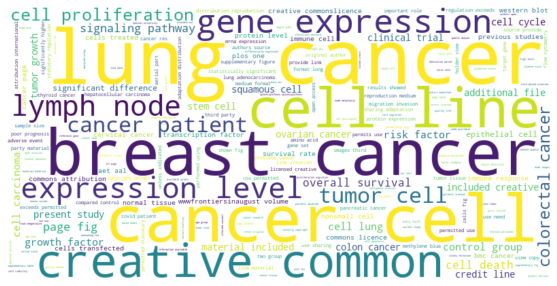

In [8]:

# Concatiner tous les textes de la colonne 'Description' en une seule chaîne
all_text = ' '.join(df['Description'].astype(str))

#  le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Fouille de texte 

Trouver combien le mot thyroide apparait dans la base de données

In [13]:
def count_thyroid_occurrences(text):
    matches = re.findall(r'\bThyroid\b', text, flags=re.IGNORECASE)
    return len(matches)

df['thyroid_occurrences'] = df['Description'].apply(count_thyroid_occurrences)

total_occurrences = df['thyroid_occurrences'].sum()
print(f"Le mot 'thyroide' apparaît {total_occurrences} fois dans la colonne 'Description'.")


Le mot 'thyroide' apparaît 13250 fois dans la colonne 'Description'.


## Prediction du type de cancer à partir d'un texte 

### Classificateur Naive Bayes 

In [14]:

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Création du pipeline avec un vecteur TF-IDF et un classificateur Naive Bayes multinomial
model_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

# Entraînement du modèle sur la colonne 'Description' et prédiction du type de cancer
model_pipeline.fit(train_df['Description'], train_df['Type'])
predictions = model_pipeline.predict(test_df['Description'])

accuracy = accuracy_score(test_df['Type'], predictions)
classification_rep = classification_report(test_df['Type'], predictions)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)




Accuracy: 0.92
Classification Report:
                 precision    recall  f1-score   support

  Colon_Cancer       0.90      0.87      0.89       517
   Lung_Cancer       1.00      0.99      1.00       407
Thyroid_Cancer       0.89      0.91      0.90       590

      accuracy                           0.92      1514
     macro avg       0.93      0.93      0.93      1514
  weighted avg       0.92      0.92      0.92      1514



Prediction à partir d'un texte 

In [15]:
# Exemple de prédiction sur un nouveau texte
new_text = """Thyroid surgery in  children in a single institution from 
Osama Ibrahim Almosallama Ali Aseerib Ahmed Alhumaida Ali S AlZahranic Saif Alsobhib Saud 
AlShanafeybFrom the  aDepartment of Surgery College of Medicine Qassim University Buraidah 
Al Qassim Saudi Arabia  bDepartment of Surgery King Faisal Specialist Hospital and Research 
Center Riyadh Saudi Arabia cDepartment of Medicine King Faisal Specialist Hospital and Research 
Center Riyadh Saudi Arabia Correspondence   Dr  Osama Ibrahim  Almosallam  Department of  Surgery  
College  of  Medicine Qassim  University  PO  Box   Buraidah  Al  Qassim   Saudi  Arabia  osama_iaahotmailcom 
ORCID orcid0000000290367564        Citation  Almosallam OI Aseeri A Alhumaid A AlZahrani AS Alsobhi S AlShanafey S 
Thyroid surgery in  children  in  a  single  institution  from   Ann  Saudi  Med         Received January  Accepted 
May  Published August  Copyright Copyright   Annals of Saudi Medicine Saudi Arabia This is an   access  under the Creative 
Commons AttributionNonCommercialNoDerivatives  International License CC BYNCND The details of which can be accessed at 
httpcreativecommons licensesbyncnd40Funding NoneBACKGROUND Data on thyroid surgery in children are scarceOBJECTIVE Analyze 
outcome data on thyroid surgery in a pediatric populationDESIGN Medical record reviewSETTING Tertiary health care institutionPATIENTS
AND METHODS We collected demographic and clinical data on patients  years or younger who had thyroid surgery in the period  to  
Descriptive data are presentedMAIN OUTCOME MEASURES Indications for thyroidectomy thyroid pathology complications length of stay 
and radioactive iodine treatment and recurrencesSAMPLE SIZE RESULTS Of  patients who underwent  thyroidectomy procedures   
were females and the mean age at operation was  years and   were associated with multiple endocrine neoplasia type  
There was no history of radiation exposure Eightyone patients  had fine needle aspiration FNA which correlated with the 
final histopathology in  of cases Sixtysix patients  had malignant cancer  papillary   of  patients who had neck 
dissection had lymph node metastasis and   had distant metastases to the lung Procedures included total thyroidectomy  
hemithyroidectomy  completion  and subtotal thyroidectomy  Twentythree  patients    developed  hypocalcemia    
permanent and   had unilateral recurrent laryngeal nerve injury  permanent Patients were followed up for a mean 
duration of  months median  months Of  patients with thyroid cancer   received radioactive iodine and   
had recurrence  Malignancy  is  the  commonest  indication  for  thyroid surgery  in  children  and  FNA  is 
highly  diagnostic  Hypocalcemia  and recurrent laryngeal nerve injury are significant complications The recurrence
rate in thyroid cancer is  LIMITATIONS RetrospectiveCONFLICT OF INTEREST Noneoriginal ANN SAUDI MED  JULYAUGUST 
WWWANNSAUDIMEDNET 0cThyroid  diseases  requiring  surgery  are  relatively uncommon in children compared to adults 
The prevalence  of  palpable  thyroid  nodules  in  children  ranges  from    to    Sporadic  welldifferentiated 
thyroid cancer is the most common endocrine malignancy in children accounting for  of pediatric cancers  in  the  
prepubertal  age  group  and  up  to   of cancers in adolescents aged � year2 The most common indication for 
thyroid surgery in children varies among published studies but thyroidectomy for malignant conditions is rising38 
Data in children throughout the  world  are  relatively  scarce  The  objective  of  this study was to analyze the 
clinical data and outcome of thyroid  surgery  in  a  large  series  of  children  treated  at a  single  center  at  
King  Faisal  Specialist  Hospital  and Research Center KFSHRC in RiyadhPATIENT AND METHODS With the approval of the 
Institutional Review Board IRB at KFSHRC the medical records of all patients  years old and younger who underwent a 
thyroid surgery between    and    were  retrospectively  reviewed We elected to include patients up to the year 
to ensure a reasonable followup period Patients for the study were identified by a search of the operating room log 
for all procedures involving the thyroid gland for the specified age groupDemographic  data  clinical  features  and  
surgical outcomes  were  collected  Specific  data  that  were  obtained included age at operation gender family history 
presenting  symptoms  history  of  radiation  exposure presence of multiple endocrine neoplasia type  MEN   thyroid  function  *test  presence  and  size  of  thyroid nodules by ultrasound presence of lymph nodes metastasis or distant metastasis fine needle aspiration FNA cytology  surgical  procedure  final  histopathology  and length of followup Outcomes analyzed were postoperative complications including transient or permanent hypocalcemia  transient  or  permanent  recurrent  laryngeal nerve paralysis wound infection and hematoma length of stay and radioactive iodine treatment and recurrences Thyroid procedures in this series included hemithyroidectomy  subtotal  total  and  completion  thyroidectomy Surgeries were performed by either an endocrine adult surgeon or a pediatric surgeon No intraoperative nerve monitoring was used Early in the series procedures were performed by adult endocrine surgeons but lately a combined approach was adopted where pediatric surgeons and adult endocrine surgeons collaborated in such cases  proceduresthe normal range in our laboratory regardless of symptoms Transient hypocalcemia was identified if it lasted for less than  months while permanent hypocalcemia was  considered  if  the  serum  calcium  level  remained below normal range and the patient continued on calcium  supplementation  after    months  of  the  surgery All patients with a family history of MEN  underwent genetic testing of the RET protooncogene to confirm the diagnosis All patients who underwent completion thyroidectomy  had  a  preoperative  and  postoperative vocal  cords  assessment  at  the  Otolaryngology  clinic Descriptive data were generated and comparisons were conducted using the t test for continuous data and the chisquare or Fisher exact tests for proportionsRESULTSBetween    and      patients  underwent   surgical  procedures    patients  underwent  two  procedures  for  thyroid  disease  at  our  institution  Eighty  patients  were females The mean age at operation was  years median  years range  years The most common indication for thyroidectomy was thyroid nodule which was present in   of cases Table  The mean SD size of thyroid nodules was   mm There were  cases  associated with MEN  syndromes The final pathology in two patients with MEN syndrome showed medullary thyroid cancer MTC while the remaining  patients had prophylactic procedures before development of MTC None of the patients had a history of radiation exposure Eightyone patients  FNA  which  correlated  with  the  final  histopathology  in  of cases There were three cases of toxic adenoma and one case of Graves� disease which did not require FNA  The  remaining  cases  underwent  FNA  at  another institution and FNA was not repeated at our institution or they came for completion thyroidectomy with documented  pathology  for  malignancy  after  they  had  their first surgery in another hospitalThe  most  common  diagnoses  included  papillary thyroid cancer  and multinodular goiter or colloid Table  Indications for thyroidectomy in  patients IndicationNodulen  MEN  prophylaxisHyperthyroidismMultinodular goiterCompletion thyroidectomy    Hypocalcemia was defined by calcium levels below Data are number  original PEDIATRIC THYROID SURGERYANN SAUDI MED  JULYAUGUST WWWANNSAUDIMEDNET 0cnodule  Table  Surgical procedures included total thyroidectomy  hemithyroidectomy  completion  thyroidectomy    and  subtotal  thyroidectomy  Neck dissection was performed in   patients  Operative  complications  were  observed in    patients    The  most  common  complication was hypocalcemia  transient  permanent and Table  Thyroid pathology in the  patientsPathologyn  BenignNormal thyroid tissueColloid noduleCystAdenomaThyroiditisGraves� diseaseThyroid cancerPapillaryFollicularMedullaryHurthleAnaplasticTotalData are number              Table  Benign and malignant lesions in  patientsBenignn37Malignantn66 P value  Age meanyearsGender malefemalePresence of noduleHypocalcemiaRecurrent laryngeal nerve palsyBleedinghematomaWound infectionTracheal injuryOverall complicationsMean length of stay daysMEN recurrent laryngeal nerve palsy  transient  permanent all were unilateral Table  Of  patients with malignant lesions   had lymph node metastasis and  patients  had distant metastases to the lung  None  of  the  patients  developed  postoperative bleeding wound infection or tracheal injury Patients were followed up for a mean of  months median   range    months  radioactive  iodine  treatment  was  delivered  to    patients    with  malignant  lesions    patients    had  recurrences   were  local  recurrences  and    were  local  and  distant recurrences to the lung Three cases received radioactive iodine RAI before and after recurrence One case was low risk before recurrence so did not receive RAI until after recurrence One case had medullary thyroid cancer  so  did  not  receive  RAI  In  the  remaining  five cases  there was no clear data whether those patients received RAI before or only after a recurrence All local recurrences  underwent  resection  except  for  one  patient who was lost follow up There was no mortality in this study DISCUSSIONThe most common indication for thyroidectomy in this series was thyroid nodule which correlates with previously published reports in the pediatric population35 Children with thyroid nodules have an estimated fourfold  higher  risk  of  developing  thyroid  cancer  compared to adults910 
The high incidence of malignancy in this series suggests children with a thyroid nodule should be carefully """
new_prediction = model_pipeline.predict([new_text])
print(f"Prédiction pour le nouveau texte : {new_prediction[0]}")

Prédiction pour le nouveau texte : Thyroid_Cancer


Modele avec couche LSTM 

In [9]:

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Tokenisation
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['Description'])

# Conversion des textes en séquences d'entiers
X_train = tokenizer.texts_to_sequences(train_data['Description'])
X_test = tokenizer.texts_to_sequences(test_data['Description'])

# Ajout de padding pour obtenir des sequences de meme longueur
X_train = pad_sequences(X_train, padding='post', maxlen=50)
X_test = pad_sequences(X_test, padding='post', maxlen=50)

# Encodage des labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['Type'])
y_test = label_encoder.transform(test_data['Type'])

# Nombre de classes
num_classes = len(label_encoder.classes_)

# Creation du modèle
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=50),
    LSTM(100),
    Dense(num_classes, activation='softmax')  # Utilisation de softmax pour une classification multiclasses
])

# Compilation du modele
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrainement
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


Epoch 1/5
152/152 [==============================] - 24s 142ms/step - loss: 0.5703 - accuracy: 0.7322 - val_loss: 0.1062 - val_accuracy: 0.9637
Epoch 2/5
152/152 [==============================] - 21s 138ms/step - loss: 0.0651 - accuracy: 0.9734 - val_loss: 0.0732 - val_accuracy: 0.9695
Epoch 3/5
152/152 [==============================] - 21s 138ms/step - loss: 0.0498 - accuracy: 0.9779 - val_loss: 0.0523 - val_accuracy: 0.9744
Epoch 4/5
152/152 [==============================] - 21s 138ms/step - loss: 0.0388 - accuracy: 0.9787 - val_loss: 0.0452 - val_accuracy: 0.9761
Epoch 5/5
48/48 [==============================] - 1s 11ms/step - loss: 0.0470 - accuracy: 0.9808
Test Accuracy: 0.98


prediction 

In [16]:
import numpy as np

#nv texte
new_text_sequence = tokenizer.texts_to_sequences([new_text])
new_text_padded = pad_sequences(new_text_sequence, padding='post', maxlen=50)

# prediction
new_prediction = model.predict(new_text_padded)

# Convertir les probabilités en classe prédite
predicted_class = np.argmax(new_prediction)

# Décoder la classe prédite en label d'origine
predicted_label = label_encoder.inverse_transform([predicted_class])[0]

# Afficher le résultat
print(f"Texte : {new_text}")
print(f"Type de cancer prédit : {predicted_label}")


1/1 [==============================] - 1s 725ms/step
Texte : Thyroid surgery in  children in a single institution from 
Osama Ibrahim Almosallama Ali Aseerib Ahmed Alhumaida Ali S AlZahranic Saif Alsobhib Saud 
AlShanafeybFrom the  aDepartment of Surgery College of Medicine Qassim University Buraidah 
Al Qassim Saudi Arabia  bDepartment of Surgery King Faisal Specialist Hospital and Research 
Center Riyadh Saudi Arabia cDepartment of Medicine King Faisal Specialist Hospital and Research 
Center Riyadh Saudi Arabia Correspondence   Dr  Osama Ibrahim  Almosallam  Department of  Surgery  
College  of  Medicine Qassim  University  PO  Box   Buraidah  Al  Qassim   Saudi  Arabia  osama_iaahotmailcom 
ORCID orcid0000000290367564        Citation  Almosallam OI Aseeri A Alhumaid A AlZahrani AS Alsobhi S AlShanafey S 
Thyroid surgery in  children  in  a  single  institution  from   Ann  Saudi  Med         Received January  Accepted 
May  Published August  Copyright Copyright   Annals of Saudi Me